# Specviz Simple Demo

**Use case:** This notebook demonstrates how to inspect spectra in Specviz, export spectra from the GUI in the notebook, select regions in the GUI and in the notebook, and measure the redshift of a source in the GUI.<br>
**Data:** NIRISS 1D Simulated Spectrum. The dataset is a JWST/NIRISS simulation of a generic scene with extended sources generated with the code MIRAGE (https://mirage-data-simulator.readthedocs.io/en/latest/) and run through the JWST calibration pipeline (https://jwst-pipeline.readthedocs.io/en/latest/).<br>
**Tools:** specutils, jdaviz.<br>
**Cross-intrument:** all instruments.<br>
**Documentation:** This notebook is part of a STScI's larger [post-pipeline Data Analysis Tools Ecosystem](https://jwst-docs.stsci.edu/jwst-post-pipeline-data-analysis).<br>

**Updated on**: 2021/3/4

In [1]:
#to use 100% of the browser window
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

/tmp/ipykernel_2779/785940443.py:2: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display, HTML


Imports:
- matplotlib for plotting data
- astropy for handling of fits files, units, and tables
- specutils for interactions with Specviz and region definition/extraction
- jdaviz for the visualization tool Specviz

In [2]:
#plotting and tabling
import matplotlib.pyplot as plt

#import astropy
import astropy
import astropy.units as u
from astropy.io import fits
from astropy.nddata import StdDevUncertainty
from astropy.table import QTable

#import specutils
import specutils
from specutils import Spectrum1D, SpectralRegion
from specutils.manipulation import extract_region

#import viztools
import jdaviz
from jdaviz import Specviz

In [3]:
#customization of matplotlib style
plt.rcParams["figure.figsize"] = (10,5)
params={'legend.fontsize':'18','axes.labelsize':'18',
        'axes.titlesize':'18','xtick.labelsize':'18',
        'ytick.labelsize':'18','lines.linewidth':2,
        'axes.linewidth':2,'animation.html': 'html5',
        'figure.figsize':(8,6)}
plt.rcParams.update(params)
plt.rcParams.update({'figure.max_open_warning': 0})

Check versions

In [4]:
print('astropy:',astropy.__version__)
print('specutils:',specutils.__version__)
print('jdaviz:',jdaviz.__version__)

astropy: 5.3
specutils: 1.11.0
jdaviz: 3.5.0


## 1. Load NIRISS pipeline output
The JWST/NIRISS simulation is stored on box. We work with the x1d file which contains all extracted 1D spectra.

In [5]:
filelink = 'https://data.science.stsci.edu/redirect/JWST/jwst-data_analysis_tools/specviz_notebook_gui_interaction/basic_F150W_WFSSR_dit1_x1d.fits'
hdu = fits.open(filelink)

hdu.info()

Filename: /home/runner/.astropy/cache/download/url/33545d5dbd50d26d5a9838f2d2259699/contents
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU     259   ()      
  1  EXTRACT1D     1 BinTableHDU     47   3R x 9C   [D, D, D, D, D, J, D, D, D]   
  2  EXTRACT1D     2 BinTableHDU     47   19R x 9C   [D, D, D, D, D, J, D, D, D]   
  3  EXTRACT1D     3 BinTableHDU     47   78R x 9C   [D, D, D, D, D, J, D, D, D]   
  4  EXTRACT1D     4 BinTableHDU     47   107R x 9C   [D, D, D, D, D, J, D, D, D]   
  5  EXTRACT1D     5 BinTableHDU     47   110R x 9C   [D, D, D, D, D, J, D, D, D]   
  6  EXTRACT1D     6 BinTableHDU     47   107R x 9C   [D, D, D, D, D, J, D, D, D]   
  7  EXTRACT1D     7 BinTableHDU     47   105R x 9C   [D, D, D, D, D, J, D, D, D]   
  8  EXTRACT1D     8 BinTableHDU     47   112R x 9C   [D, D, D, D, D, J, D, D, D]   
  9  EXTRACT1D     9 BinTableHDU     47   107R x 9C   [D, D, D, D, D, J, D, D, D]   
 10  EXTRACT1D    10 BinTableHDU 

## 2. Open Specviz and load all the 1D spectra
Parsers are not ready for all instruments, so we load the spectrum manually and we write in a Spectrum1D.

**Developer note:**

We need a parser for NIRISS WFSS x1d.fits files.

In [6]:
viz = Specviz()
viz.app

Application(config='specviz', events=['call_viewer_method', 'close_snackbar_message', 'data_item_remove', 'dat…

The following cell opens one-by-one the extensions of the x1d file, creates Spectrum1D objects for all the spectra, and loads them into Specviz. A mask is set to only keep the part of the spectra with good sensitivity (1.34 to 1.66 micron) in the F150W filter. The for loop runs from 2 to 19, because spectra 0 and 1 have very short extraction boxes and are not useful for this work (this can be seen in the dimentions of the extensions of the fits file). The spectra are also inverted. The pipeline extracts them in reverse wavelength order because the dispersion direction is from right to left on the detector.

In [7]:
for i in range (2,19):
    spec_load = hdu[i+1].data

    #invert axis
    wave = spec_load['WAVELENGTH']
    flux = spec_load['FLUX']
    error = spec_load['ERROR']
    invwave = wave[::-1]
    invflux = flux[::-1]
    inverror = error[::-1]

    #mask the parts where the sensitivity in the bandpass is poor
    mask = ((invwave>1.34) & (invwave<1.66))

    spec1d = Spectrum1D(spectral_axis=invwave[mask]*u.um, 
                    flux=invflux[mask]*u.Jy, 
                    uncertainty=StdDevUncertainty(inverror[mask]*u.Jy)) #
    
    viz.load_spectrum(spec1d,"NIRISS 1D {}".format(str(i+1)))

    #print(spec1d)

This is just for quick look to see all the spectra that are in the file. We can go to the hammer and screwdriver icon, then the gear icon and select/deselect the spectra. We find our favorite spectrum (NIRISS ID 6) and work with that.

## 3. Select the emission lines using the GUI and in the notebook
I open the hammer and screwdriver menu and click the "Select range of x values" icon. Then I select the region spanning the emission lines from roughly 1.35 to 1.43 microns.

Instructions: https://jdaviz.readthedocs.io/en/latest/specviz/displaying.html#defining-spectral-regions

### See what data is used in this specviz istance

In [8]:
dataout = viz.get_spectra()
spec1d_line = dataout["NIRISS 1D 6"]

/opt/hostedtoolcache/Python/3.11.4/x64/lib/python3.11/site-packages/jdaviz/configs/specviz/helper.py:131: UserWarning: Applying the value from the redshift slider to the output spectra. To avoid seeing this warning, explicitly set the apply_slider_redshift keyword option to True or False.
  warnings.warn("Applying the value from the redshift "


In [9]:
print(spec1d_line)

Spectrum1D (length=69)
flux:             [ 1.17e-06 Jy, ..., 1.3069e-06 Jy ],  mean=1.4173e-06 Jy
spectral axis:    [ 1.3402 um, ..., 1.6585 um ],  mean=1.4994 um
uncertainty:      [ StdDevUncertainty(0.), ..., StdDevUncertainty(0.) ]


### See the subsets defined in the GUI
I include a try-except in case the notebook is run without human interaction.

In [10]:
try:
    region = viz.get_spectral_regions()
    print(region['Subset 1'])
except:
    print("No region defined in the GUI")

No region defined in the GUI


### Select the same region programmatically
I can define my own region (cont_region) between arbitrary bounds. I choose 1.35um and 1.42um. I can then extract the spectrum in that region.

In [11]:
cont_region = SpectralRegion(1.35*u.um,1.42*u.um)
spec1d_el_code = extract_region(spec1d_line, cont_region)
print(spec1d_el_code)

Spectrum1D (length=15)
flux:             [ 1.6059e-06 Jy, ..., 1.3176e-06 Jy ],  mean=2.4411e-06 Jy
spectral axis:    [ 1.3543 um, ..., 1.4198 um ],  mean=1.387 um
uncertainty:      [ StdDevUncertainty(0.), ..., StdDevUncertainty(0.) ]


Or I can extract the spectrum in the region I defined in the GUI (region['Subset 1']).

In [12]:
try:
    spec1d_el_viz = extract_region(spec1d_line, region['Subset 1'])
    print(spec1d_el_viz)
except:
    print("Region was not defined in the GUI")
    #define spec1d_el_viz as spec1d_el_code
    spec1d_el_viz = spec1d_el_code

Region was not defined in the GUI


### Plot the spectrum and the subset with matplotlib

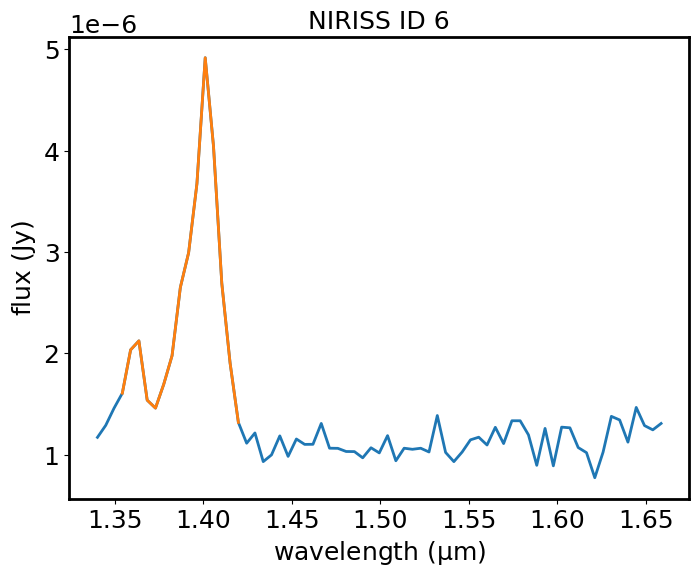

In [13]:
plt.plot(spec1d_line.spectral_axis,spec1d_line.flux)
plt.plot(spec1d_el_viz.spectral_axis,spec1d_el_viz.flux)

plt.xlabel("wavelength ({:latex})".format(spec1d_line.spectral_axis.unit))
plt.ylabel("flux ({:latex})".format(spec1d_line.flux.unit))
plt.title("NIRISS ID 6")
plt.show()


## 4. Use the redshift slider in Specviz to find the redshift

I start by opening a new instance of Specviz so that I do not have to scroll up and down too much.

In [14]:
viz2 = Specviz()
viz2.app

Application(config='specviz', events=['call_viewer_method', 'close_snackbar_message', 'data_item_remove', 'dat…

I load just the interesting spectrum (spec1d_line).

In [15]:
viz2.load_spectrum(spec1d_line,"NIRISS 1D lines")

I can use an available line lists or define my own lines (I know I need Hb4861.3 and the [OIII]4958.9,5006.8 doublet) and play with the redshift slider to match the lines in the line list with the lines in the spectrum. The line list plugin can be found clicking the Lego icon on the upper right of the viewer. To input just the three lines, I can use the "Custom" menu.

Here is the documentation where line lists are explained: https://jdaviz.readthedocs.io/en/latest/specviz/plugins.html#line-lists

I can also define the lines of interest programmatically, as shown in the following cell.

In [16]:
lt = QTable()
lt['linename'] = ['Hb','[OIII]1','[OIII]2']
lt['rest'] = [4861.3,4958.9,5006.8]*u.AA

viz2.load_line_list(lt)

The lines are not showing now because their rest value is outside the range plotted here. I can move the lines using the redshift slider at the top. It is best to first set the redshift to 2 in the box with the number and then move the slider to bring the lines on top of the observed emission lines.

### Get the redshift out in the Spectrum1D object

In [17]:
spec1d_redshift = viz2.get_spectra()["NIRISS 1D lines"]
print(spec1d_redshift)

print()

if spec1d_redshift.redshift != 0.0:
    print("NIRISS 1D lines redshift=",spec1d_redshift.redshift)
else:
    print("Redshift was not defined in GUI. Defining it here.")
    spec1d_redshift.redshift = 1.798
    print("NIRISS 1D lines redshift=",spec1d_redshift.redshift)

/opt/hostedtoolcache/Python/3.11.4/x64/lib/python3.11/site-packages/jdaviz/configs/specviz/helper.py:131: UserWarning: Applying the value from the redshift slider to the output spectra. To avoid seeing this warning, explicitly set the apply_slider_redshift keyword option to True or False.
  warnings.warn("Applying the value from the redshift "
        Use set_redshift_to or shift_spectrum_to instead. [warnings]
        Use set_redshift_to or shift_spectrum_to instead.


Spectrum1D (length=69)
flux:             [ 1.17e-06 Jy, ..., 1.3069e-06 Jy ],  mean=1.4173e-06 Jy
spectral axis:    [ 1.3402 um, ..., 1.6585 um ],  mean=1.4994 um
uncertainty:      [ StdDevUncertainty(0.), ..., StdDevUncertainty(0.) ]

Redshift was not defined in GUI. Defining it here.
NIRISS 1D lines redshift= 1.7979999999999996


## 5. Model the continuum of the spectrum

I open another instance of Specviz and load the same specrum used before.

In [18]:
viz3 = Specviz()
viz3.app

Application(config='specviz', events=['call_viewer_method', 'close_snackbar_message', 'data_item_remove', 'dat…

In [19]:
viz3.load_spectrum(spec1d_line,"NIRISS 1D lines")

I can use the GUI to select the region where I see the continuum. This is between 1.45 and 1.63 microns roughly. To do so, I go to the hammer and screwdriver icon and use the Select Region button.

I can then use the Model Fitting plugin under the Lego icon to fit a linear model to the selected region. Instructions can be found here: https://jdaviz.readthedocs.io/en/latest/specviz/plugins.html#model-fitting. The individual steps to complete this task are:
- Select Subset 1 under Data
- Select Linear1D under Model
- Enter a model ID under Model ID (I use "lin")
- Click Add model
- Enter the needed combination of models under Model Equation Editor (it is just one model here, so I enter just "lin")
- Enter a name for the model under Model Label (I choose "continuum")
- Click Fit
- Click Add to viewer
- Go to the hammer and screwdiver icon, then gear icon, and select the new dataset "continuum".

I can extract the model from the datasets in use.

**Developer Note:**

I would like to be able to extract also the model parameters, not just the model spectrum. This is being worked on.

In [20]:
try:
    dataout3 = viz3.get_spectra()
    spectrum = dataout3["NIRISS 1D lines"] #this is exactly the same as the spec1d_lines loaded a few cells above
    continuum = dataout3["continuum"]
except:
    print("Continuum has not been created. Setting it to 0")
    continuum = Spectrum1D(spectral_axis=spectrum.spectral_axis, flux= 0.*spectrum.flux)

Continuum has not been created. Setting it to 0


/opt/hostedtoolcache/Python/3.11.4/x64/lib/python3.11/site-packages/jdaviz/configs/specviz/helper.py:131: UserWarning: Applying the value from the redshift slider to the output spectra. To avoid seeing this warning, explicitly set the apply_slider_redshift keyword option to True or False.
  warnings.warn("Applying the value from the redshift "


I can do a continuum subtraction and plot the result with matplotlib. If the continuum has not been defined in the GUI, this operation returns the original spectrum unchanged.

In [21]:
spectrum_sub = spectrum - continuum

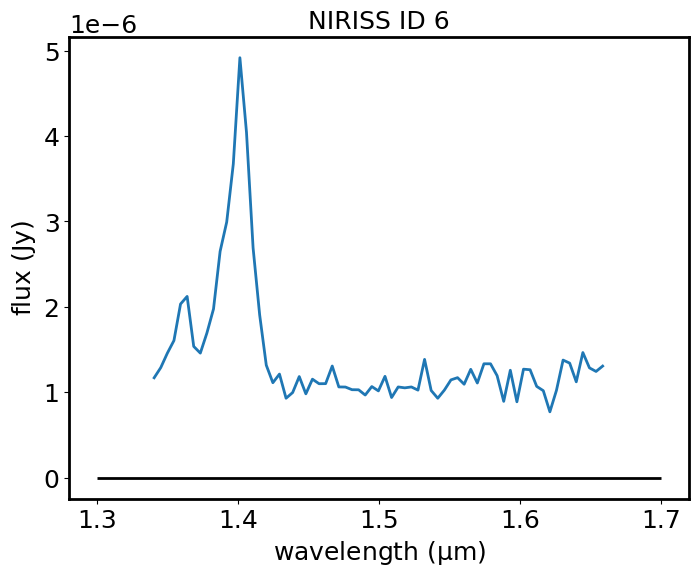

In [22]:
plt.plot(spectrum_sub.spectral_axis,spectrum_sub.flux)
plt.hlines(0,1.3,1.7,color='black')

plt.xlabel("wavelength ({:latex})".format(spectrum_sub.spectral_axis.unit))
plt.ylabel("flux ({:latex})".format(spectrum_sub.flux.unit))
plt.title("NIRISS ID 6")
plt.show()


<img style="float: right;" src="https://raw.githubusercontent.com/spacetelescope/notebooks/master/assets/stsci_pri_combo_mark_horizonal_white_bkgd.png" alt="Space Telescope Logo" width="200px"/>